In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:qwen/qwen3-32b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001CEC6F09F70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001CEC7051F10>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

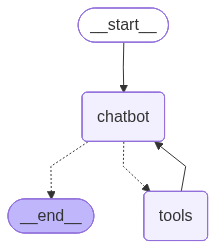

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command,interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]


@tool

def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query":query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("chatbot",chatbot)
builder.add_node("tools",ToolNode(tools))

builder.add_conditional_edges("chatbot",
                              tools_condition)

builder.add_edge(START,"chatbot")
builder.add_edge("tools","chatbot")

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [3]:
user_input = "I need expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable":{"thread_id":"1"}}
events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode= "values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (qr7q13r24)
 Call ID: qr7q13r24
  Args:
    query: I need expert guidance for building an AI agent. Could you request assistance for me?


In [4]:
human_response = (
    "We, the expertes are here to help! We'd recommend you checkout LangGraph to build your agent."
    "Tt's much more reliable and extensible than simple autonomus agents."
)

human_command = Command(resume= {"data": human_response})

events = graph.stream(human_command, config, stream_mode ="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (qr7q13r24)
 Call ID: qr7q13r24
  Args:
    query: I need expert guidance for building an AI agent. Could you request assistance for me?
================================= Tool Message =================================
Name: human_assistance

We, the expertes are here to help! We'd recommend you checkout LangGraph to build your agent.Tt's much more reliable and extensible than simple autonomus agents.
================================== Ai Message ==================================

The expert recommends exploring **LangGraph** for building your AI agent, highlighting its reliability and extensibility compared to simpler autonomous agent frameworks. To proceed:

1. **What is LangGraph?**  
   LangGraph is a framework designed for building scalable, production-ready language model applications. It emphasizes modularity, allowing you to define workflows as directed acyclic graphs